In [1]:
import os
import os.path as osp

import time
import os, mmap
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import add_self_loops
from sklearn.manifold import TSNE
import numpy as np
from torch_geometric.datasets import Planetoid
import nvsmi
import threading
import psutil

# Using MMAP LoadData

In [15]:
from ctypes import *
result = cdll.LoadLibrary("./mmaploader.so")


# str_test="need_bytes"  
# val=str_test.encode()  
# func.strTest.restype = c_char_p
# file = c_char("/mnt/mem/cora.cites")
start_time = time.perf_counter()

file = bytes("/mnt/mem/cora.cites",encoding='utf-8')
result.readMMap.restype = c_char_p
cites = result.readMMap(file, 0, 10000);

file = bytes("/mnt/mem/cora.content",encoding='utf-8')
result.readMMap.restype = c_char_p
content = result.readMMap(file, 0, 200000000);

end_time = time.perf_counter()
# result.closemmap(bytes(m,encoding='utf-8'))

In [16]:
print('Loading time: ' + str(end_time - start_time))

Loading time: 0.015206213000055868


In [17]:
# Index dictionary, converting the original paper id to encode from 0
index_dict = dict()
# Tag dictionary, converting string tags to values
label_to_index = dict()

features = []
labels = []
edge_index = []
# start timer
start_time = time.perf_counter()

nodes = content.decode().split("\n")[:-1]
for node in nodes:
    node_info = node.split()
    print(node_info)
    index_dict[int(node_info[0])] = len(index_dict)
    features.append([int(i) for i in node_info[1:-1]])

    label_str = node_info[-1]
    if (label_str not in label_to_index.keys()):
        label_to_index[label_str] = len(label_to_index)
    labels.append(label_to_index[label_str])

edges = cites.decode().split("\n")[:-1]
for edge in edges:
    start, end = edge.split()
    # The edges are treated as undirected for training purposes, but the original edges are directed, 
    #so they need to be added forward and backward twice
    edge_index.append([index_dict[int(start)], index_dict[int(end)]])
    edge_index.append([index_dict[int(end)], index_dict[int(start)]])

# end timer
end_time = time.perf_counter()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['447250', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [18]:
print('Data proccessing time: ' + str(end_time - start_time))

Data proccessing time: 1.0564958569998453


# Using DirectIO LoadData

In [19]:
import directio
path = "/mnt/mem/"
cites = path + "cora.cites"
content = path + "cora.content"

# Index dictionary, converting the original paper id to encode from 0
index_dict = dict()
# Tag dictionary, converting string tags to values
label_to_index = dict()

features = []
labels = []
edge_index = []
# start timer
start_time = time.perf_counter()

# fd = open(cites, "r")
fd_o = os.open(content, os.O_DIRECT | os.O_RDONLY)
# print(fd)
# m = mmap.mmap(fd, 0)
content = directio.read(fd_o,10521600)

fd_o1 = os.open(cites, os.O_DIRECT | os.O_RDONLY)
cites = directio.read(fd_o1,70144)

end_time = time.perf_counter()
print('Loading time: ' + str(end_time - start_time))



Loading time: 0.004048715999942942


In [20]:
start_time = time.perf_counter()
nodes = content.decode().split("\n")[:-1]
for node in nodes:
    node_info = node.split()
#     print(node_info)
    index_dict[int(node_info[0])] = len(index_dict)
    features.append([int(i) for i in node_info[1:-1]])

    label_str = node_info[-1]
    if (label_str not in label_to_index.keys()):
        label_to_index[label_str] = len(label_to_index)
    labels.append(label_to_index[label_str])

edges = cites.decode().split("\n")[:-1]
for edge in edges:
    start, end = edge.split()
    # The edges are treated as undirected for training purposes, but the original edges are directed, 
    #so they need to be added forward and backward twice
    edge_index.append([index_dict[int(start)], index_dict[int(end)]])
    edge_index.append([index_dict[int(end)], index_dict[int(start)]])
end_time = time.perf_counter()


In [21]:
print('Data proccessing time: ' + str(end_time - start_time))

Data proccessing time: 0.5696297260001302


# Create Dataset

In [22]:
# To Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# norm
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index = torch.LongTensor(edge_index)

In [23]:
mask = torch.randperm(len(index_dict))
train_mask = mask[0:2708]
val_mask = mask[0:2708]
test_mask = mask[0:2708]

dataset = Data(x=features, edge_index=edge_index.t().contiguous(), y=labels, num_classes =7,test_mask=test_mask, train_mask=train_mask, val_mask=val_mask)
print(dataset)

Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708], num_classes=7, test_mask=[2708], train_mask=[2708], val_mask=[2708])


# Test system evaluation metric

In [24]:
import nvsmi
import threading
import psutil
import os
import os.path as osp


disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    while True:
        if not t_status:
            break
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
#         print(f"{disk_usage / 1024 / 1024} Mb/s")
#         time.sleep(0.09)

# Sampling

In [26]:
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Reddit
import torch
from torch_geometric.loader import NeighborSampler
# from NS import NeighborSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from SAGEConv import SAGEConv
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler

# from torch.utils.data import DataLoader

start_time = time.time()
t = threading.Thread(target=get_gpu_info)
t.start()
train_loader = NeighborSampler(dataset.edge_index, node_idx=dataset.train_mask,
                               sizes=[10, 10], batch_size=128, shuffle=True,
                               num_workers=2)
t_status = False
t.join()

# # Reddit
# train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
#                                sizes=[25, 10], batch_size=1024, shuffle=True,
#                                num_workers=8,pin_memory=True)

end_time = time.time()
init_sample_time = end_time - start_time
print('NeighborSampler time:{}'.format(end_time - start_time))
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')


subgraph_loader = NeighborSampler(dataset.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False,
                                  num_workers=2)


NeighborSampler time:0.043172597885131836
内存使用：0.3515 GB
磁盘IO使用：0.1048 GB/s
磁盘IO使用率：2.1905%
cpu iowait：1.6664973071842292e-05


/home/jason/anaconda3/envs/finalproject/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


In [29]:
# gpu_data = list(nvsmi.get_gpus())[0]
# start_gpu_util = gpu_data.gpu_util
# start_gpu_mem_use = gpu_data.mem_used
# total_gpu_mem = gpu_data.mem_total
disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
# group_gpu_util = []
# group_gpu_mem_use = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    
    while True:
        if not t_status:
            break
#         gpu_data = list(nvsmi.get_gpus())[0]
#         group_gpu_util.append(gpu_data.gpu_util)
#         group_gpu_mem_use.append(gpu_data.mem_used)
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
        time.sleep(1)


class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


# cora
model = SAGENet(dataset.num_features, 16, dataset.num_classes)

# Reddit
# model = SAGENet(dataset.num_features, 256, dataset.num_classes)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model
model.to(device)
data = dataset.to(device)
print(dataset)

x = dataset.x.to(device)
y = dataset.y.squeeze().to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)

        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(x[n_id], adjs)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / int(data.train_mask.sum())

    return loss, approx_acc, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

    return results

# def test():  # Inference should be performed on the full graph.
#     model.eval()

#     out = model.inference(data.x)
#     y_pred = out.argmax(dim=-1)

#     accs = []
#     for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         correct = y_pred[mask].eq(data.y[mask]).sum().item()
#         accs.append(correct / mask.sum().item())
#     return accs


lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 11):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, acc, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
print("========================================================")
# print(f"GPU 显存占用: {np.mean(group_gpu_mem_use)}Mb")
# print(f"GPU 显存占用率: {np.mean(group_gpu_mem_use) * 100 / total_gpu_mem}%")
# print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
# tmp_ = sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
# print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

SAGENet(
  (convs): ModuleList(
    (0): SAGEConv(1433, 16)
    (1): SAGEConv(16, 7)
  )
)
cpu
Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708], num_classes=7, test_mask=[2708], train_mask=[2708], val_mask=[2708])


Epoch 01:   0%|                        | 2708/3665278 [00:00<16:26, 3712.54it/s]


Epoch 01, Loss: 1.1346, Approx. Train: 0.0004


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 13579.86it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 02:   0%|                        | 2708/3665278 [00:00<11:13, 5436.50it/s]


Epoch 02, Loss: 0.4503, Approx. Train: 0.0006


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 18095.24it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 03:   0%|                        | 2708/3665278 [00:00<10:39, 5724.71it/s]


Epoch 03, Loss: 0.3148, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 16026.23it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 04:   0%|                        | 2708/3665278 [00:00<15:24, 3962.59it/s]


Epoch 04, Loss: 0.2445, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 18168.85it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 05:   0%|                        | 2708/3665278 [00:00<10:11, 5990.51it/s]


Epoch 05, Loss: 0.2295, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 20811.27it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 06:   0%|                        | 2708/3665278 [00:00<09:49, 6217.05it/s]


Epoch 06, Loss: 0.1991, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 20274.31it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 07:   0%|                        | 2708/3665278 [00:00<10:40, 5717.83it/s]


Epoch 07, Loss: 0.2034, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 17693.17it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 08:   0%|                        | 2708/3665278 [00:00<09:59, 6107.56it/s]


Epoch 08, Loss: 0.1882, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 12460.47it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 09:   0%|                        | 2708/3665278 [00:00<18:17, 3338.35it/s]


Epoch 09, Loss: 0.1798, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 17476.23it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007


Epoch 10:   0%|                        | 2708/3665278 [00:00<18:34, 3285.39it/s]


Epoch 10, Loss: 0.1738, Approx. Train: 0.0007


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 19150.02it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007
Average linear time: 11.529994010925293 ms
Average message time: 0.10852813720703125 ms
Average aggregate time: 126.5625238418579 ms
Average update time: 9.947752952575684 ms
Average sample time: 165.42298293113708 ms
内存使用：0.3704 GB
磁盘IO使用：0.1104 GB/s
磁盘IO使用率：2.2443%
cpu iowait：0.0
Total training and evaluation time: 10.065265417098999


# Training on DRAM

# Test system evaluation metric

In [4]:
import nvsmi
import threading
import psutil
import os
import os.path as osp


disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    while True:
        if not t_status:
            break
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
#         print(f"{disk_usage / 1024 / 1024} Mb/s")
#         time.sleep(0.09)

# Loading data and sampling

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Reddit
import torch
from torch_geometric.loader import NeighborSampler
# from NS import NeighborSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from SAGEConv import SAGEConv
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time

# from torch.utils.data import DataLoader

dataset = Planetoid(root='./cora/', name='Cora')
# dataset = Planetoid(root='./citeseer',name='Citeseer')
# dataset = Planetoid(root='./pubmed/',name='Pubmed')
# dataset = Reddit(root='./reddit/')
print(dataset)

start_time = time.time()
t = threading.Thread(target=get_gpu_info)
t.start()
train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
                               sizes=[10, 10], batch_size=128, shuffle=True,
                               num_workers=8)
t_status = False
t.join()

# # Reddit
# train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
#                                sizes=[25, 10], batch_size=1024, shuffle=True,
#                                num_workers=8,pin_memory=True)

end_time = time.time()
init_sample_time = end_time - start_time
print('NeighborSampler time:{}'.format(end_time - start_time))
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')


subgraph_loader = NeighborSampler(dataset[0].edge_index, node_idx=None, sizes=[-1],
                                  batch_size=1024, shuffle=False,
                                  num_workers=8)

Cora()
NeighborSampler time:0.017145872116088867
内存使用：0.3192 GB
磁盘IO使用：0.1202 GB/s
磁盘IO使用率：0.5393%
cpu iowait：0.013043478260869565


# Traning

In [7]:
gpu_data = list(nvsmi.get_gpus())[0]
start_gpu_util = gpu_data.gpu_util
start_gpu_mem_use = gpu_data.mem_used
total_gpu_mem = gpu_data.mem_total
disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_gpu_util = []
group_gpu_mem_use = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    
    while True:
        if not t_status:
            break
        gpu_data = list(nvsmi.get_gpus())[0]
        group_gpu_util.append(gpu_data.gpu_util)
        group_gpu_mem_use.append(gpu_data.mem_used)
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
        time.sleep(1)


class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


# cora
model = SAGENet(dataset.num_features, 16, dataset.num_classes)

# Reddit
# model = SAGENet(dataset.num_features, 256, dataset.num_classes)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.cuda()
model.to(device)
data = dataset[0].to(device)
print(data)

x = data.x.to(device)
y = data.y.squeeze().to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)

        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(x[n_id], adjs)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / int(data.train_mask.sum())

    return loss, approx_acc, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

    return results

# def test():  # Inference should be performed on the full graph.
#     model.eval()

#     out = model.inference(data.x)
#     y_pred = out.argmax(dim=-1)

#     accs = []
#     for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         correct = y_pred[mask].eq(data.y[mask]).sum().item()
#         accs.append(correct / mask.sum().item())
#     return accs


lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 11):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, acc, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
print("========================================================")
print(f"GPU 显存占用: {np.mean(group_gpu_mem_use)}Mb")
print(f"GPU 显存占用率: {np.mean(group_gpu_mem_use) * 100 / total_gpu_mem}%")
print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
tmp_ = sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

SAGENet(
  (convs): ModuleList(
    (0): SAGEConv(1433, 16)
    (1): SAGEConv(16, 7)
  )
)
cpu
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Epoch 01: 100%|██████████████████████████████| 140/140 [00:00<00:00, 501.11it/s]


Epoch 01, Loss: 1.9180, Approx. Train: 0.1786


Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 10357.10it/s]


Train: 0.6786, Val: 0.3980, Test: 0.3790


Epoch 02: 100%|██████████████████████████████| 140/140 [00:00<00:00, 601.54it/s]


Epoch 02, Loss: 1.7132, Approx. Train: 0.5357


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 6483.30it/s]


Train: 0.8214, Val: 0.4740, Test: 0.4690


Epoch 03: 100%|██████████████████████████████| 140/140 [00:00<00:00, 408.45it/s]


Epoch 03, Loss: 1.3342, Approx. Train: 0.6857


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 9257.93it/s]


Train: 0.9286, Val: 0.5280, Test: 0.5140


Epoch 04: 100%|██████████████████████████████| 140/140 [00:00<00:00, 456.82it/s]


Epoch 04, Loss: 1.0256, Approx. Train: 0.7714


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 7888.54it/s]


Train: 0.9786, Val: 0.6220, Test: 0.6060


Epoch 05: 100%|██████████████████████████████| 140/140 [00:00<00:00, 494.03it/s]


Epoch 05, Loss: 0.8855, Approx. Train: 0.7929


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 6918.08it/s]


Train: 1.0000, Val: 0.6640, Test: 0.6590


Epoch 06: 100%|██████████████████████████████| 140/140 [00:00<00:00, 465.74it/s]


Epoch 06, Loss: 0.6382, Approx. Train: 0.9000


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 9598.78it/s]


Train: 1.0000, Val: 0.7060, Test: 0.7130


Epoch 07: 100%|██████████████████████████████| 140/140 [00:00<00:00, 456.56it/s]


Epoch 07, Loss: 0.4938, Approx. Train: 0.9071


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 6827.32it/s]


Train: 1.0000, Val: 0.7240, Test: 0.7470


Epoch 08: 100%|██████████████████████████████| 140/140 [00:00<00:00, 435.60it/s]


Epoch 08, Loss: 0.4381, Approx. Train: 0.9714


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 7742.55it/s]


Train: 1.0000, Val: 0.7320, Test: 0.7600


Epoch 09: 100%|██████████████████████████████| 140/140 [00:00<00:00, 443.56it/s]


Epoch 09, Loss: 0.2483, Approx. Train: 0.9500


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 9091.41it/s]


Train: 1.0000, Val: 0.7380, Test: 0.7670


Epoch 10: 100%|██████████████████████████████| 140/140 [00:00<00:00, 414.97it/s]


Epoch 10, Loss: 0.2504, Approx. Train: 0.9500


Evaluating: 100%|█████████████████████████| 5416/5416 [00:00<00:00, 8263.22it/s]


Train: 1.0000, Val: 0.7360, Test: 0.7640
Average linear time: 1.7604351043701172 ms
Average message time: 0.022721290588378906 ms
Average aggregate time: 14.043784141540527 ms
Average update time: 1.5317678451538086 ms
Average sample time: 163.68031859397888 ms
内存使用：0.3851 GB
磁盘IO使用：0.1237 GB/s
磁盘IO使用率：0.5547%
cpu iowait：0.05
Total training and evaluation time: 10.122181177139282


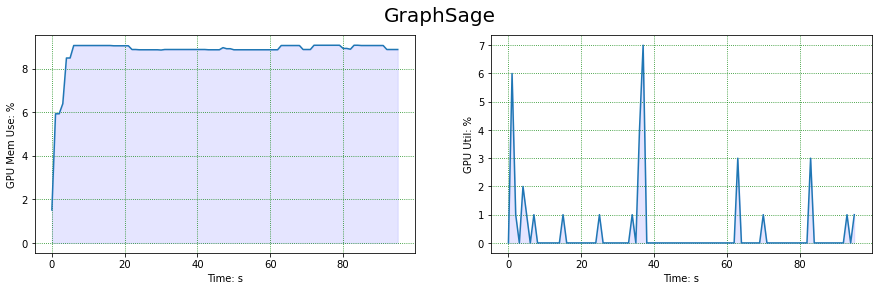

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
x = range(0,len(group_gpu_mem_use),1)
plt.plot(x,np.true_divide( np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100)
plt.fill_between(x, np.true_divide(np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Mem Use: %")
plt.grid(linestyle=":", color="green")
plt.subplot(1,2,2)
x = range(0,len(group_gpu_util),1)
plt.plot(x,np.array(group_gpu_util)-start_gpu_util)
plt.fill_between(x, np.array(group_gpu_util)-start_gpu_util, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Util: %")
plt.grid(linestyle=":", color="green")
plt.suptitle("GraphSage",fontsize=20)
plt.savefig("./figure/SmallSage.png")
plt.show()

In [ ]:
Pumped

GPU 显存占用: 6875.0Mb
GPU 显存占用率: 83.92333984375%
GPU 平均使用率: 0.0%
GPU 空闲率: 100.0%
内存使用：2.2513 GB
磁盘IO使用：2.7416 GB/s
磁盘IO使用率：2.0843%
cpu iowait：0.0
Total training and evaluation time: 356.5854079723358
    
    